# Entendimento do Problema e Planejamento da Solução

    O que preciso entregar? 
            Web App com modelo em produção fazendo previsões de inadimplência e taxa de juros personalizada.
    
    O que precisa ser feito? 
             Construção do Modelo;
             Deployment do Modelo;
         
    Quais ferramentas utilizar? 
           - Python
               1. Biblioteca de manipulação de dados(Pandas,Numpy e Scipy)
               2. Biblioteca de Machine Learning (Scikit-Learn)
               3. Biblioteca de Balanceamento de Dados (Imbalanced Learn)
               4. Biblioteca de Vizualização de Dados (Matplotlib e Seaborn)
            - Flask (Escrever a Handler API)
            - Render (Cloud para Deployment)
            - Streamlit ou Hugging Face (Web APP)
    
    Como fazer? 
            1. Fazer todo o processo de construção do modelo;
            2. Escrever Handler API para chamar o pipeline de tratamento de dados e fazer request no modelo; 
            3. Fazer deployment da aplicação no Render; 
            4. Construir o webapp utilizando o streamlit;

## Metadados

1: Inadimplente
0: Não inadimplente


X1: Amount of the given credit (NT dollar): it includes
both the individual consumer credit and his/her family
(supplementary) credit.
 X2: Gender (1 = male; 2 = female).
 X3: Education (1 = graduate school; 2 = university;
3 = high school; 4 = others).
 X4: Marital status (1 = married; 2 = single; 3 = others).
 X5: Age (year).
 X6–X11: History of past payment. We tracked the past
monthly payment records (from April to September,
2005) as follows: X6 = the repayment status in Septem-
ber, 2005; X7 = the repayment status in August,
2005; . . .; X11 = the repayment status in April, 2005.
The measurement scale for the repayment status is:
1 = pay duly; 1 = payment delay for one month;
2 = payment delay for two months; . . .; 8 = payment
delay for eight months; 9 = payment delay for nine
months and above.
 X12–X17: Amount of bill statement (NT dollar).
X12 = amount of bill statement in September, 2005;
X13 = amount of bill statement in August,
2005; . . .; X17 = amount of bill statement in April, 2005.
 X18–X23: Amount of previous payment (NT dollar).
X18 = amount paid in September, 2005; X19 = amount
paid in August, 2005; . . .; X23 = amount paid in April,
2005.

# PASSO 0 - Imports

In [1]:
import math
import pandas as pd
import numpy  as np
import inflection
import requests
import random
import pickle
import warnings
import xgboost as xgb
import seaborn as sns


from boruta               import BorutaPy
from scipy                import stats      as ss
from matplotlib           import pyplot     as plt
from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

'''    
from sklearn.metrics import make_scorer, average_precision_score
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    auprc = []
    auprc_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)
    
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        safra = x_training['SAFRA'].min()
        validation_start_safra = safra + 1
        #validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['SAFRA'] < validation_start_safra]
        validation = x_training[(x_training['SAFRA'] == validation_start_safra) ]

        # training and validation dataset
        # training
        xtraining = training.drop( ['ID', 'SAFRA' , 'default'], axis=1 )
        ytraining = training['default']
        
        # validation
        xvalidation = validation.drop( ['ID', 'SAFRA' , 'default'], axis=1 )
        yvalidation = validation['default']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict_proba(xvalidation)[:, 1]
        
        
        # performance
        auprc = auprc_scorer(m, xvalidation, yvalidation)
        
        # 
        auprc.append(  m_result['MAE'] )
        

    return pd.DataFrame( {'Model Name': model_name, 
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str )}
                          '''

"    \nfrom sklearn.metrics import make_scorer, average_precision_score\ndef cross_validation( x_training, kfold, model_name, model, verbose=False ):\n    auprc = []\n    auprc_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)\n    \n    \n    for k in reversed( range( 1, kfold+1 ) ):\n        if verbose:\n            print( '\nKFold Number: {}'.format( k ) )\n        # start and end date for validation \n        safra = x_training['SAFRA'].min()\n        validation_start_safra = safra + 1\n        #validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)\n\n        # filtering dataset\n        training = x_training[x_training['SAFRA'] < validation_start_safra]\n        validation = x_training[(x_training['SAFRA'] == validation_start_safra) ]\n\n        # training and validation dataset\n        # training\n        xtraining = training.drop( ['ID', 'SAFRA' , 'default'], axis=1 )\n        ytraining = training['default']\n

## 0.1 Loading Data

In [3]:
df_raw = pd.read_csv('data/dataset_trat.csv', sep=';')

In [4]:
df_raw.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,200510,20000,2,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,200510,120000,2,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,200510,90000,2,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,200510,50000,2,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,200510,50000,1,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df_raw.shape

(30000, 26)

In [6]:
df_raw.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default'],
      dtype='object')

In [7]:
df_raw['SEX'].unique()

array([2, 1])

In [8]:
df_raw['SEX'] = df_raw['SEX'].apply(lambda x: 'male' if x==1 else 'female')

In [9]:
df_raw['SEX'].unique()

array(['female', 'male'], dtype=object)

In [10]:
df_raw['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [11]:
df_raw['EDUCATION'] = df_raw['EDUCATION'].apply(lambda x: 'graduate school' if x == 1 else 'university' if x==2 else
                                               'high school' if x==3 else 'others')

In [12]:
df_raw['EDUCATION'].unique()

array(['university', 'graduate school', 'high school', 'others'],
      dtype=object)

In [13]:
df_raw['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [14]:
df_raw['MARRIAGE'] = df_raw['MARRIAGE'].apply(lambda x: 'married' if x==1 else 'single' if x==2 else 'others')

In [15]:
df_raw['MARRIAGE'].unique()

array(['married', 'single', 'others'], dtype=object)

## 0.2 Divisão do Conjunto de Dados

In [16]:
df_raw.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [17]:
print("O dataset tem {:.2f}% de inadimplentes." .format(df_raw[df_raw['default'] == 1].shape[0]*100/df_raw.shape[0]))

O dataset tem 22.12% de inadimplentes.


In [18]:
# Out of Time(OOT)
df_OOT = df_raw[df_raw['SAFRA'] > 200604].copy()

In [19]:
df_OOT.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
21000,21001,200605,30000,male,university,married,36,1,-1,-1,...,1170,780,0,780,0,1170,0,0,0,0
21001,21002,200605,280000,male,high school,married,40,2,0,0,...,191291,189029,192023,10000,9000,8000,6738,6974,7600,1
21002,21003,200605,260000,male,university,married,37,0,0,0,...,23186,14117,15797,3203,6015,5055,2011,4078,4522,0
21003,21004,200605,200000,male,university,single,32,2,0,0,...,0,0,0,7600,4000,0,0,0,0,1
21004,21005,200605,80000,male,university,single,32,2,0,0,...,67352,74448,72928,3000,4005,2500,10000,0,5000,1


In [20]:
df_OOT['SAFRA'].groupby(df_OOT['SAFRA']).count()

SAFRA
200605    3000
200606    3000
200607    3000
Name: SAFRA, dtype: int64

In [21]:
df0_dev = df_raw[df_raw['SAFRA'] <= 200604].copy()
df0_dev.head()

,ID,SAFRA,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,200510,20000,female,university,married,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,200510,120000,female,university,single,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,200510,90000,female,university,single,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,200510,50000,female,university,married,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,200510,50000,male,university,married,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [22]:
print("O dataset de treino tem {:.2f}% de inadimplentes." .format(df0_dev[df0_dev['default'] == 1].shape[0]*100/df0_dev.shape[0]))
print("O dataset de teste tem {:.2f}% de inadimplentes." .format(df_OOT[df_OOT['default'] == 1].shape[0]*100/df_OOT.shape[0]))

O dataset de treino tem 22.84% de inadimplentes.
O dataset de teste tem 20.44% de inadimplentes.


In [23]:
# df0_dev é o dataset que será usado para construir o modelo.
# df_OOT é o dataset que será usado para testar o modelo. OOT(Out of time)

# PASSO 1 - Data Description

In [24]:
#A patir deste ponto usararemos apenas o dataset de treino. O objetivo é não ter data leakage. 
df1 = df0_dev.copy()

In [25]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of columns: {}' .format(df1.shape[1]))

Number of Rows: 21000
Number of columns: 26


In [26]:
df1.dtypes

ID            int64
SAFRA         int64
LIMIT_BAL     int64
SEX          object
EDUCATION    object
MARRIAGE     object
AGE           int64
PAY_0         int64
PAY_2         int64
PAY_3         int64
PAY_4         int64
PAY_5         int64
PAY_6         int64
BILL_AMT1     int64
BILL_AMT2     int64
BILL_AMT3     int64
BILL_AMT4     int64
BILL_AMT5     int64
BILL_AMT6     int64
PAY_AMT1      int64
PAY_AMT2      int64
PAY_AMT3      int64
PAY_AMT4      int64
PAY_AMT5      int64
PAY_AMT6      int64
default       int64
dtype: object

In [27]:
df1.isna().sum()

ID           0
SAFRA        0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [28]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributtes = df1.select_dtypes(exclude=['int64','float64'])

In [29]:
#Central Tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ID,1.0,21000.0,20999.0,10500.500000,10500.5,6062.177820,0.000000,-1.200000
1,SAFRA,200510.0,200604.0,94.0,200563.285714,200601.0,45.291798,-0.288063,-1.915213
2,LIMIT_BAL,10000.0,1000000.0,990000.0,163276.365714,130000.0,128677.638299,1.028252,0.602996
3,AGE,21.0,79.0,58.0,35.415286,34.0,9.246949,0.734517,0.045975
4,PAY_0,-2.0,8.0,10.0,0.018476,0.0,1.123405,0.807518,3.099244
5,PAY_2,-2.0,8.0,10.0,-0.103238,0.0,1.203886,0.820207,1.673044
6,PAY_3,-2.0,8.0,10.0,-0.136238,0.0,1.209314,0.917693,2.444372
7,PAY_4,-2.0,8.0,10.0,-0.196381,0.0,1.169821,1.070557,3.897242
8,PAY_5,-2.0,8.0,10.0,-0.234857,0.0,1.144504,1.061523,4.143238
9,PAY_6,-2.0,8.0,10.0,-0.261762,0.0,1.167988,1.002820,3.507251


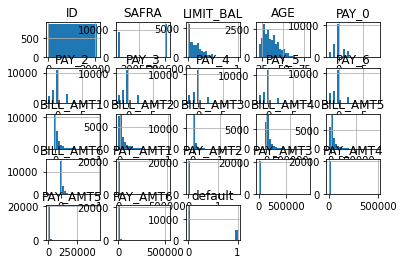

In [30]:
num_attributes.hist(bins=24);

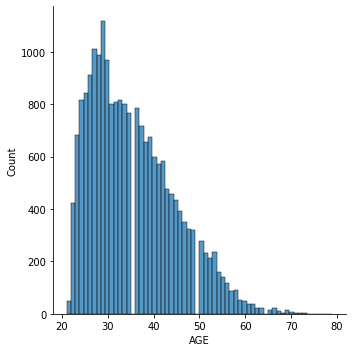

In [31]:
sns.displot(df1['AGE']);

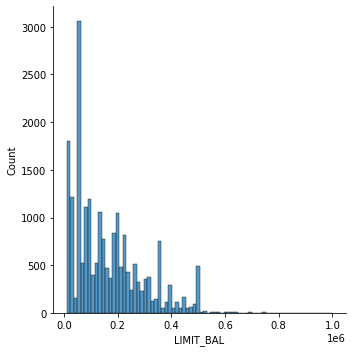

In [32]:
sns.displot(df1['LIMIT_BAL']);

## 1.2 Categorical Attributes

In [33]:
cat_attributtes.apply(lambda x: x.unique().shape[0])

SEX          2
EDUCATION    4
MARRIAGE     3
dtype: int64

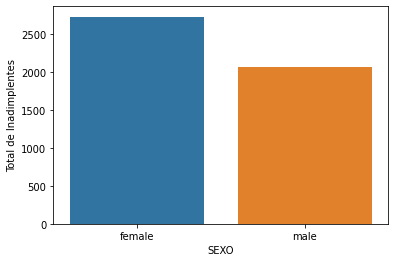

In [34]:
aux = df1.loc[df1['default']==1]
aux1 = aux[['SEX','default']].groupby('SEX').sum().reset_index()
sns.barplot(data=aux1 , x='SEX' , y='default');
plt.xlabel('SEXO')
plt.ylabel('Total de Inadimplentes')
plt.show();

Text(0, 0.5, 'Total de Inadimplentes')

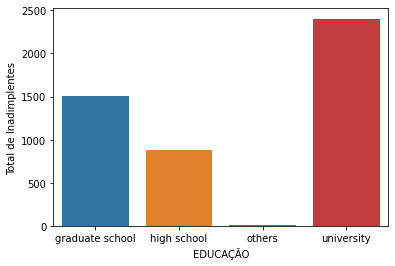

In [35]:
aux2 = aux[['EDUCATION','default']].groupby('EDUCATION').sum().reset_index()
sns.barplot(data=aux2 , x='EDUCATION' , y='default');
plt.xlabel('EDUCAÇÃO')
plt.ylabel('Total de Inadimplentes')

Text(0, 0.5, 'Total de Inadimplentes')

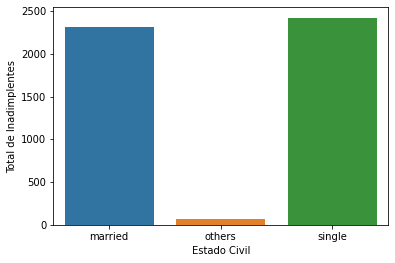

In [36]:
aux3 = aux[['MARRIAGE','default']].groupby('MARRIAGE').sum().reset_index()
sns.barplot(data=aux3 , x='MARRIAGE' , y='default');
plt.xlabel("Estado Civil")
plt.ylabel('Total de Inadimplentes')

# PASSO 2 - Feature Engeneering

In [37]:
df2 = df1.copy()

In [38]:
df2.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default'],
      dtype='object')

In [39]:
df2['SUM_BILL'] = df2['BILL_AMT1'] + df2['BILL_AMT2'] + df2['BILL_AMT3'] + df2['BILL_AMT4'] + df2['BILL_AMT5'] + df2['BILL_AMT6']   
df2['AVG_BILL'] = df2['SUM_BILL'] / 6
df2['max_BILL'] = df2[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)

df2['SUM_PAY'] = df2['PAY_AMT1'] + df2['PAY_AMT2'] + df2['PAY_AMT3'] + df2['PAY_AMT4'] + df2['PAY_AMT5'] + df2['PAY_AMT6']
df2['AVG_PAY'] = df2['SUM_PAY'] / 6
df2['max_PAY'] = df2[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']].max(axis=1)

In [40]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,21000.0,10500.500000,6062.322162,1.000000,5250.750000,10500.500000,15750.250000,2.100000e+04
SAFRA,21000.0,200563.285714,45.292876,200510.000000,200511.000000,200601.000000,200603.000000,2.006040e+05
LIMIT_BAL,21000.0,163276.365714,128680.702162,10000.000000,50000.000000,130000.000000,230000.000000,1.000000e+06
AGE,21000.0,35.415286,9.247169,21.000000,28.000000,34.000000,41.000000,7.900000e+01
PAY_0,21000.0,0.018476,1.123432,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_2,21000.0,-0.103238,1.203915,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_3,21000.0,-0.136238,1.209342,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_4,21000.0,-0.196381,1.169849,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_5,21000.0,-0.234857,1.144531,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_6,21000.0,-0.261762,1.168015,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00


In [41]:
#Construindo as mesmas fetures no dataset de teste
df_OOT['SUM_BILL'] = df_OOT['BILL_AMT1'] + df_OOT['BILL_AMT2'] + df_OOT['BILL_AMT3'] + df_OOT['BILL_AMT4'] + df_OOT['BILL_AMT5'] + df_OOT['BILL_AMT6']   
df_OOT['AVG_BILL'] = df_OOT['SUM_BILL'] / 6
df_OOT['max_BILL'] = df_OOT[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)

df_OOT['SUM_PAY'] = df_OOT['PAY_AMT1'] + df_OOT['PAY_AMT2'] + df_OOT['PAY_AMT3'] + df_OOT['PAY_AMT4'] + df_OOT['PAY_AMT5'] + df_OOT['PAY_AMT6']
df_OOT['AVG_PAY'] = df_OOT['SUM_PAY'] / 6
df_OOT['max_PAY'] = df_OOT[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']].max(axis=1)

Metadados sobre a variável (PAY_)
-1 = pay duly;
1 = payment delay for one month;
2 = payment delay for two months; . . .;
8 = payment delay for eight months; 
9 = payment delay for nine months and above.

# PASSO 3 - Variable Filtering

In [42]:
df3 = df2.copy()

# PASSO 4 - EDA 

In [43]:
df4 = df3.copy()

## Análise Univariada

In [44]:
df4.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default', 'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY',
       'max_PAY'],
      dtype='object')

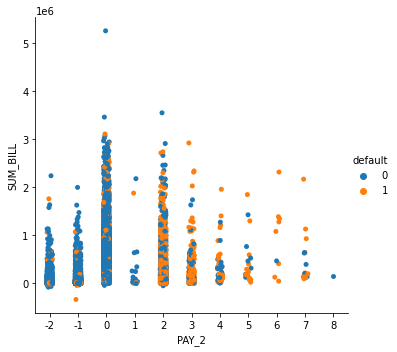

In [45]:
sns.catplot(data=df4,x='PAY_2',y='SUM_BILL',hue='default');

## Análise Bivariada

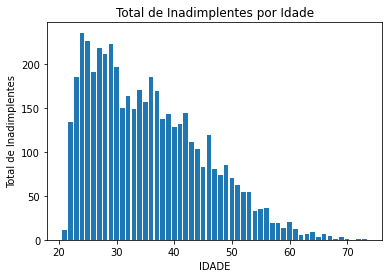

In [46]:
df4_aux = df4[df4['default']==1].copy()
aux = df4_aux[['AGE','default']].groupby('AGE').count().reset_index()
plt.bar(aux['AGE'], aux['default'])
plt.xlabel('IDADE')
plt.ylabel('Total de Inadimplentes')
plt.title('Total de Inadimplentes por Idade')
plt.show()

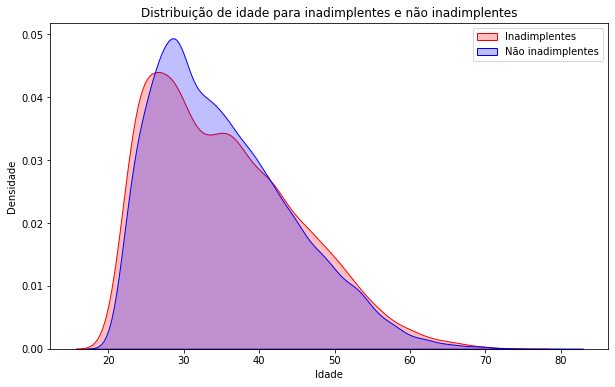

In [47]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['AGE'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['AGE'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Idade')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição de idade para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

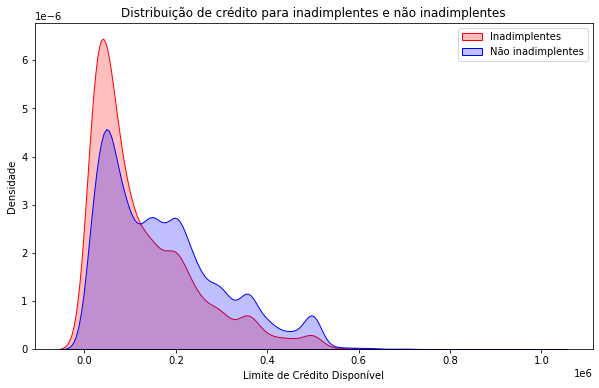

In [48]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['LIMIT_BAL'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['LIMIT_BAL'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Limite de Crédito Disponível')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição de crédito para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

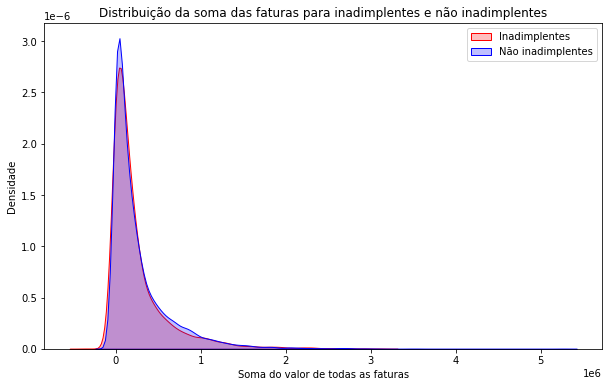

In [49]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['SUM_BILL'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['SUM_BILL'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Soma do valor de todas as faturas')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição da soma das faturas para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

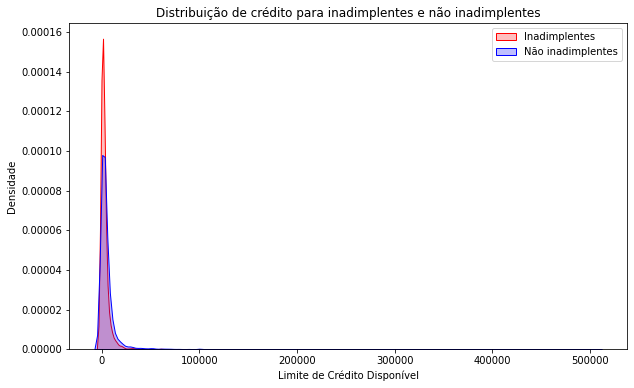

In [50]:
# Filtrando os dados para inadimplentes e não inadimplentes
df4_aux1 = df4[df4['default']==1].copy()
df4_aux0 = df4[df4['default']==0].copy()

# Plotando o gráfico de densidade
fig, ax = plt.subplots(figsize=(10,6))

sns.kdeplot(df4_aux1['PAY_AMT1'], shade=True, color='red', label='Inadimplentes', ax=ax)
sns.kdeplot(df4_aux0['PAY_AMT1'], shade=True, color='blue', label='Não inadimplentes', ax=ax)

ax.set_xlabel('Limite de Crédito Disponível')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição de crédito para inadimplentes e não inadimplentes')
ax.legend()

plt.show()

In [51]:
df4.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default', 'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY',
       'max_PAY'],
      dtype='object')

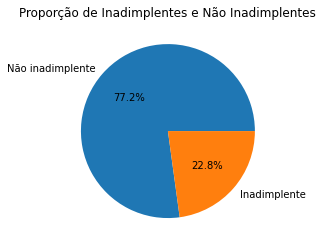

In [52]:
plt.pie(df4['default'].value_counts(), labels=['Não inadimplente', 'Inadimplente'], autopct='%1.1f%%')
plt.title('Proporção de Inadimplentes e Não Inadimplentes')
plt.show()

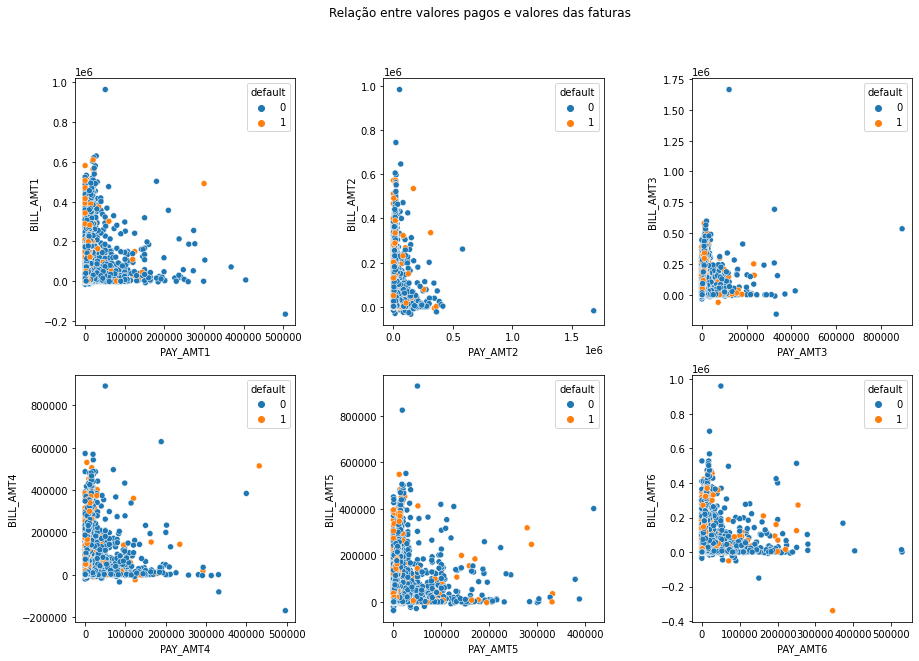

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

sns.scatterplot(x='PAY_AMT1', y='BILL_AMT1', data=df4, hue='default', ax=axs[0, 0])
sns.scatterplot(x='PAY_AMT2', y='BILL_AMT2', data=df4, hue='default', ax=axs[0, 1])
sns.scatterplot(x='PAY_AMT3', y='BILL_AMT3', data=df4, hue='default', ax=axs[0, 2])
sns.scatterplot(x='PAY_AMT4', y='BILL_AMT4', data=df4, hue='default', ax=axs[1, 0])
sns.scatterplot(x='PAY_AMT5', y='BILL_AMT5', data=df4, hue='default', ax=axs[1, 1])
sns.scatterplot(x='PAY_AMT6', y='BILL_AMT6', data=df4, hue='default', ax=axs[1, 2])

fig.subplots_adjust(wspace=0.4)
plt.suptitle('Relação entre valores pagos e valores das faturas')
plt.show()

## Análise Multivariada

In [54]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
cat_attributtes = df4.select_dtypes(exclude = ['int64','float64'])

In [55]:
corr = num_attributes.corr(method='pearson')

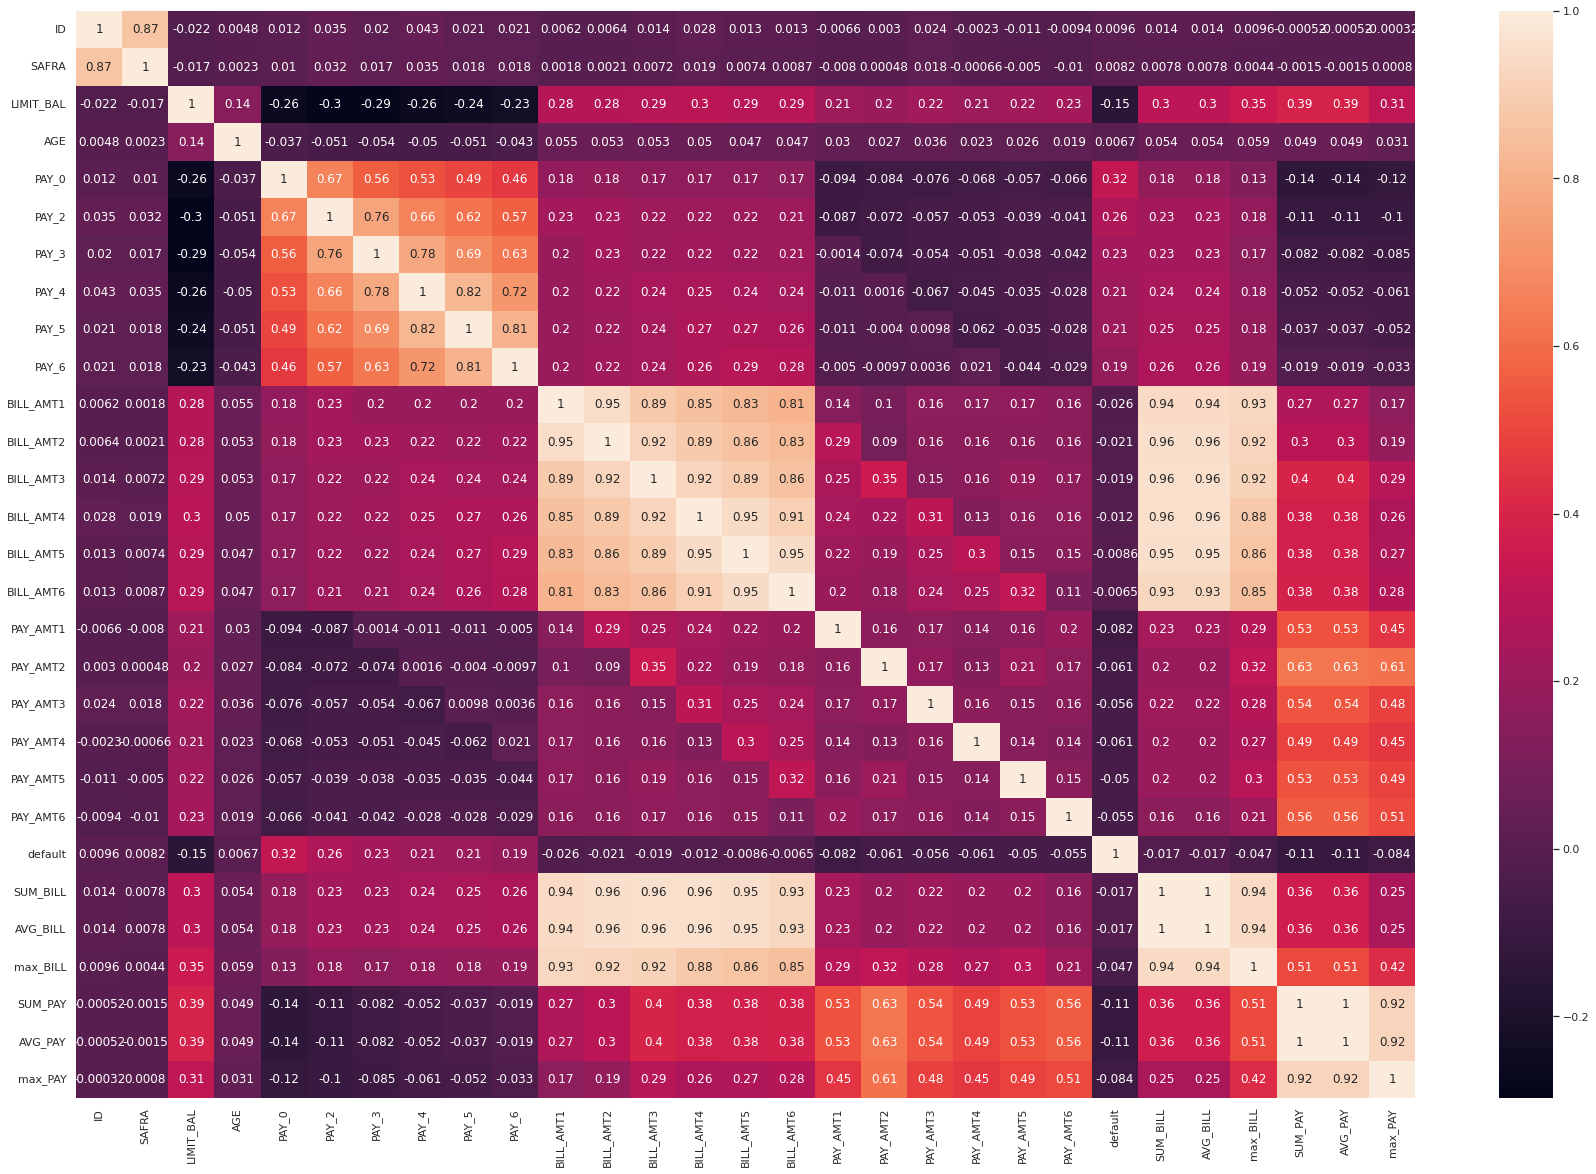

In [56]:
sns.set(rc = {'figure.figsize':(30,20)})
sns.heatmap(corr,annot=True);

In [57]:
cor_dict = dict(corr['default'])
cor_dict

{'ID': 0.009604055460692726,
 'SAFRA': 0.008226731741860024,
 'LIMIT_BAL': -0.14762038395399393,
 'AGE': 0.006701528478051911,
 'PAY_0': 0.3229564633657247,
 'PAY_2': 0.26016610314539823,
 'PAY_3': 0.23200875685031191,
 'PAY_4': 0.21263623638958556,
 'PAY_5': 0.2076795114475631,
 'PAY_6': 0.1868026192613604,
 'BILL_AMT1': -0.026488445701884078,
 'BILL_AMT2': -0.02052992056691768,
 'BILL_AMT3': -0.01872493171166154,
 'BILL_AMT4': -0.011514576260711782,
 'BILL_AMT5': -0.008615527885540127,
 'BILL_AMT6': -0.0064697798470222875,
 'PAY_AMT1': -0.08208209362654624,
 'PAY_AMT2': -0.06059355184490814,
 'PAY_AMT3': -0.055602546148258734,
 'PAY_AMT4': -0.06063337074217536,
 'PAY_AMT5': -0.04993356612501237,
 'PAY_AMT6': -0.05474585568999584,
 'default': 1.0,
 'SUM_BILL': -0.016729042818866686,
 'AVG_BILL': -0.016729042818866648,
 'max_BILL': -0.046814100631402955,
 'SUM_PAY': -0.10965885226183143,
 'AVG_PAY': -0.10965885226183161,
 'max_PAY': -0.08413782602243765}

In [58]:
select_person = []
for chave, valor in cor_dict.items():
    if (valor < -0.1 or valor > 0.1) and chave != 'default':
        select_person.append(chave)
select_person

['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'SUM_PAY',
 'AVG_PAY']

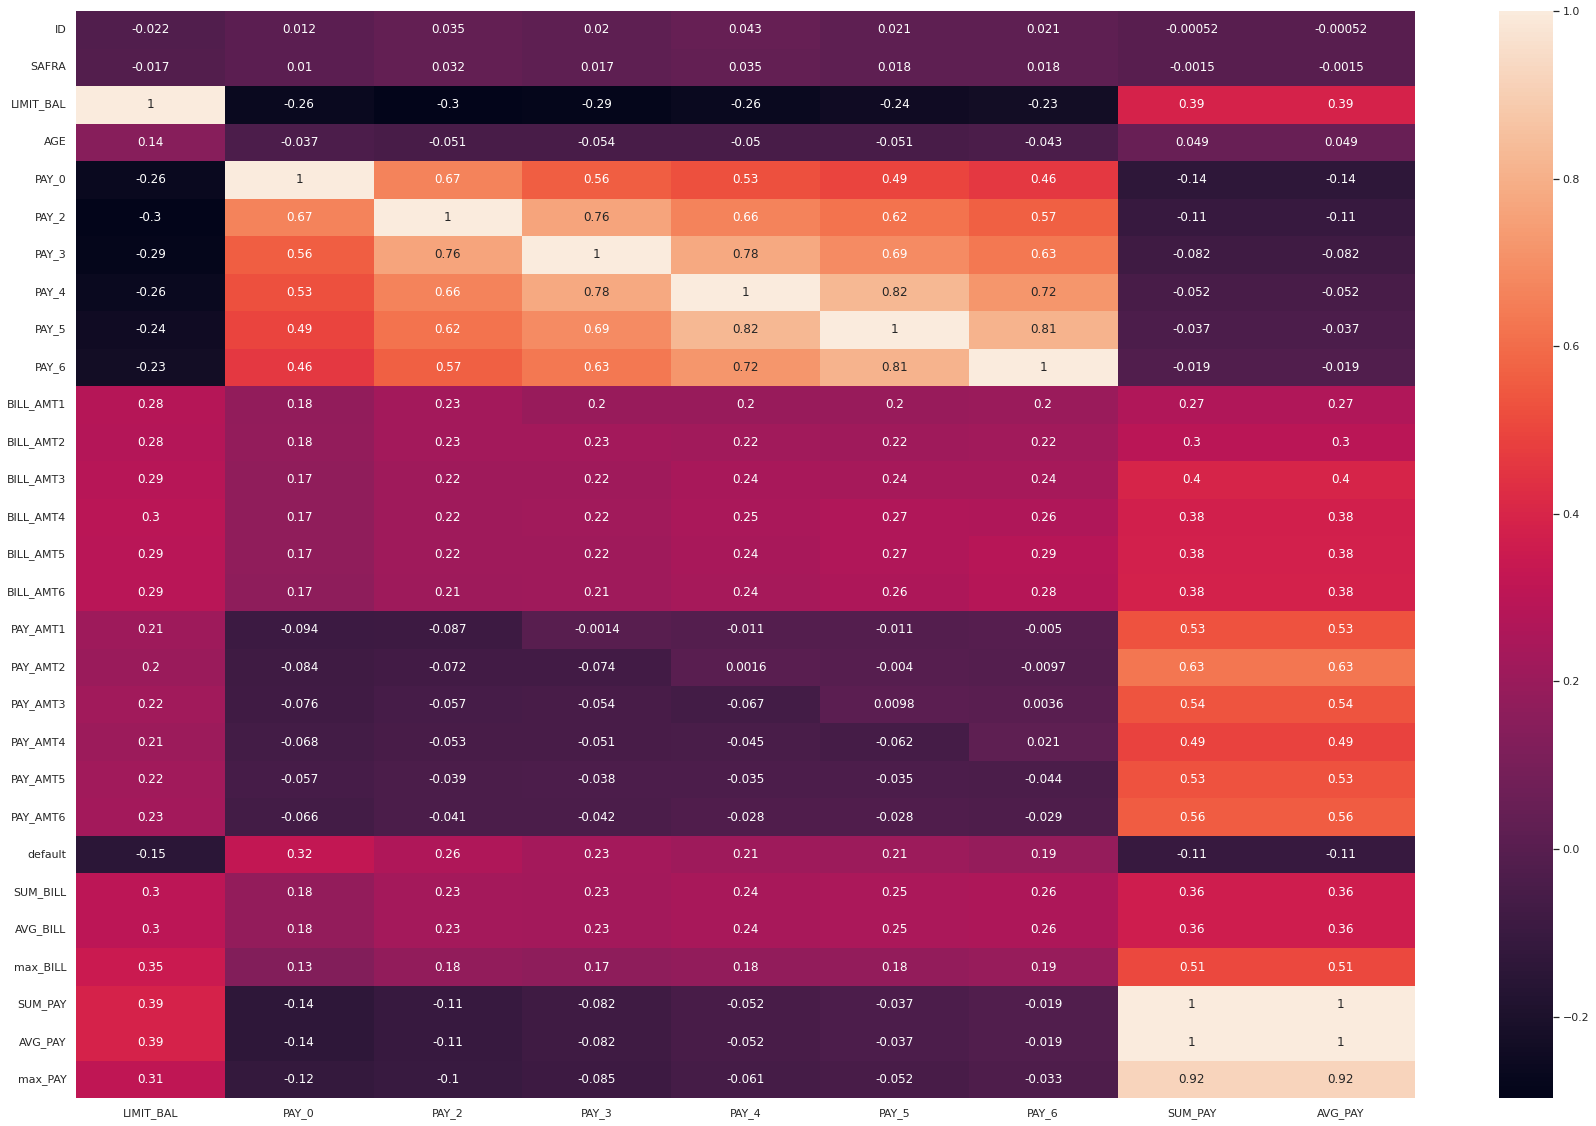

In [59]:
sns.heatmap(corr[select_person],annot=True);

<Axes: >

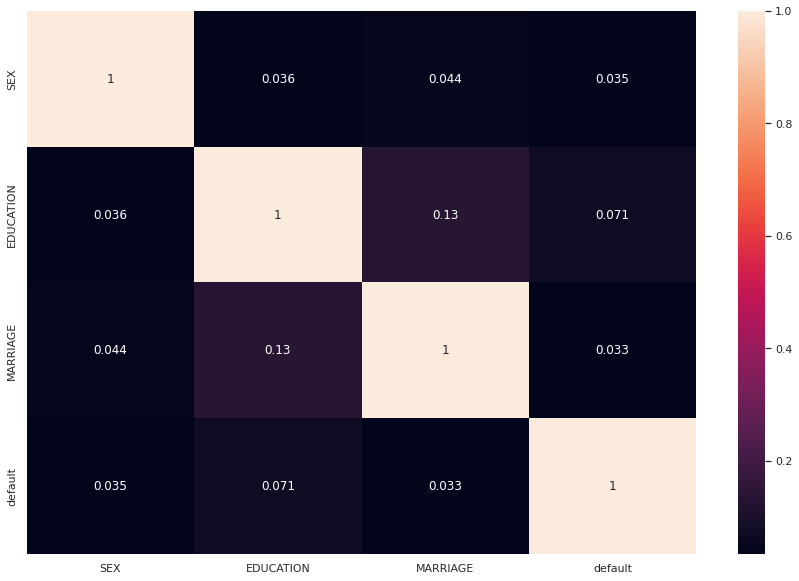

In [60]:
sns.set(rc = {'figure.figsize':(15,10)})
# only categorical data
a = df4[['SEX','EDUCATION','MARRIAGE','default']]

# Calculate cramer V
a1 = cramer_v( a['SEX'], a['SEX'] )
a2 = cramer_v( a['SEX'], a['EDUCATION'] )
a3 = cramer_v( a['SEX'], a['MARRIAGE'] )
a4 = cramer_v( a['SEX'], a['default'] )


a5 = cramer_v( a['EDUCATION'], a['SEX'] )
a6 = cramer_v( a['EDUCATION'], a['EDUCATION'] )
a7 = cramer_v( a['EDUCATION'], a['MARRIAGE'] )
a8 = cramer_v( a['EDUCATION'], a['default'] )


a9 = cramer_v( a['MARRIAGE'], a['SEX'] )
a10 = cramer_v( a['MARRIAGE'], a['EDUCATION'] )
a11 = cramer_v( a['MARRIAGE'], a['MARRIAGE'] )
a12 = cramer_v( a['MARRIAGE'], a['default'] )

a13 = cramer_v( a['default'], a['SEX'] )
a14 = cramer_v( a['default'], a['EDUCATION'] )
a15 = cramer_v( a['default'], a['MARRIAGE'] )
a16 = cramer_v( a['default'], a['default'] )


# Final dataset
d = pd.DataFrame( {'SEX': [a1, a2, a3,a4], 'EDUCATION': [a5, a6, a7,a8], 'MARRIAGE': [a9, a10, a11,a12] , 'default' : [a13,a14,a15,a16] })

d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# PASSO 5 - Data Preparation (Unbalanced DataSet)

In [72]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [73]:
df5.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default', 'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY',
       'max_PAY'],
      dtype='object')

In [74]:
cols_rescaling= ['LIMIT_BAL','BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY']

rs = RobustScaler()
df5[cols_rescaling] = rs.fit_transform(df5[cols_rescaling].values)

df_OOT[cols_rescaling] = rs.transform(df_OOT[cols_rescaling].values)

In [75]:
num_attributes = df5.select_dtypes(include=['int64' , 'float64'])

#Central Tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ID,1.000000,2.100000e+04,2.099900e+04,10500.500000,1.050050e+04,6062.177820,0.000000,-1.200000
1,SAFRA,200510.000000,2.006040e+05,9.400000e+01,200563.285714,2.006010e+05,45.291798,-0.288063,-1.915213
2,LIMIT_BAL,-0.666667,4.833333e+00,5.500000e+00,0.184869,0.000000e+00,0.714876,1.028252,0.602996
3,AGE,21.000000,7.900000e+01,5.800000e+01,35.415286,3.400000e+01,9.246949,0.734517,0.045975
4,PAY_0,-2.000000,8.000000e+00,1.000000e+01,0.018476,0.000000e+00,1.123405,0.807518,3.099244
5,PAY_2,-2.000000,8.000000e+00,1.000000e+01,-0.103238,0.000000e+00,1.203886,0.820207,1.673044
6,PAY_3,-2.000000,8.000000e+00,1.000000e+01,-0.136238,0.000000e+00,1.209314,0.917693,2.444372
7,PAY_4,-2.000000,8.000000e+00,1.000000e+01,-0.196381,0.000000e+00,1.169821,1.070557,3.897242
8,PAY_5,-2.000000,8.000000e+00,1.000000e+01,-0.234857,0.000000e+00,1.144504,1.061523,4.143238
9,PAY_6,-2.000000,8.000000e+00,1.000000e+01,-0.261762,0.000000e+00,1.167988,1.002820,3.507251


## 5.1 Transformation

### 5.1.1 Encoding

In [76]:
#Label Encoding
le = LabelEncoder()
df5['SEX'] = le.fit_transform( df5['SEX'] )
df_OOT['SEX'] = le.transform(df_OOT['SEX'])

df5['MARRIAGE'] = le.fit_transform(df5['MARRIAGE'])
df_OOT['MARRIAGE'] = le.transform(df_OOT['MARRIAGE'])


#Ordinal Encoding
df5['EDUCATION'] = df5['EDUCATION'].apply(lambda x: 1 if x=='others' else 2 if x=='high school' else 3 if x=='graduate school'
                                         else 4)
df_OOT['EDUCATION'] = df_OOT['EDUCATION'].apply(lambda x: 1 if x=='others' else 2 if x=='high school' else 3 if x=='graduate school'
                                         else 4)

### 5.1.1 Nature Transformation

# PASSO 5 - Data Preparation (Balanced DataSet)

In [62]:
df_balanced = df4.copy()

In [63]:
df_balanced.columns

Index(['ID', 'SAFRA', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default', 'SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY',
       'max_PAY'],
      dtype='object')

## Enconding

In [104]:
#label Enconder
le = LabelEncoder()
df_balanced['SEX'] = le.fit_transform( df_balanced['SEX'] )
pickle.dump(le, open('parameter/gender_scaler.pkl','wb'))

df_balanced['MARRIAGE'] = le.fit_transform(df_balanced['MARRIAGE'])
pickle.dump(le,open('parameter/marriage_scaler.pkl' , 'wb'))

#Ordinal Encoding
df_balanced['EDUCATION'] = df_balanced['EDUCATION'].apply(lambda x: 1 if x=='others' else 2 if x=='high school' else 3 if x=='graduate school'
                                         else 4)

In [65]:
#Balancinng using OverSampling(SMOTE e ADASYN)
from imblearn.over_sampling import SMOTE, ADASYN
smo = SMOTE()
ada = ADASYN()

X_train = df_balanced.drop(['ID', 'SAFRA','default'],axis=1)
y_train = df_balanced['default']

X_smo, y_smo = smo.fit_resample(X_train, y_train)
X_ada, y_ada = ada.fit_resample(X_train, y_train)

## Rescaling

In [103]:
cols_rescaling= ['LIMIT_BAL','BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','SUM_BILL', 'AVG_BILL', 'max_BILL', 'SUM_PAY', 'AVG_PAY']
rs = RobustScaler()


X_smo[cols_rescaling] = rs.fit_transform(X_smo[cols_rescaling].values)
X_ada[cols_rescaling] = rs.fit_transform(X_ada[cols_rescaling].values)

pickle.dump(rs,open('parameter/cols_scaler.pkl','wb'))

# PASSO 6 - Feature Selection 

In [78]:
df6 = df5.copy()

In [79]:
df6.dtypes

ID             int64
SAFRA          int64
LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
default        int64
SUM_BILL     float64
AVG_BILL     float64
max_BILL     float64
SUM_PAY      float64
AVG_PAY      float64
max_PAY        int64
dtype: object

In [80]:
X = df6.drop(['default','ID','SAFRA'], axis=1)
y = df6['default']

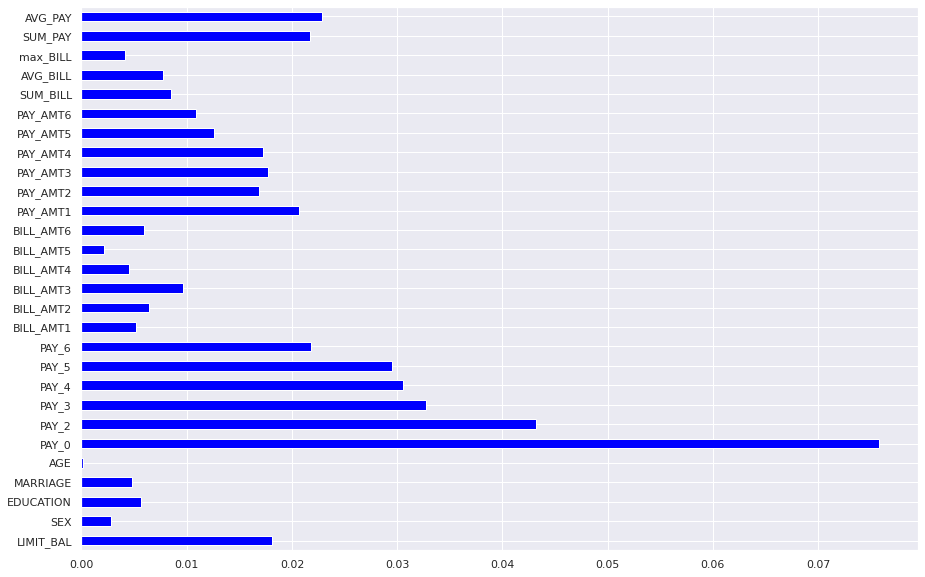

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Assuming that X and y have already been defined
importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importances = feat_importances.iloc[:28]
feat_importances.plot(kind='barh', color='blue')
plt.show()

# PASSO 7 - Machine Learning Modelling 

In [88]:
#Models which be used 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb


models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Gradient Boosting' : GradientBoostingClassifier(),
          'AdaBoostClassifier' : AdaBoostClassifier(),
          'GaussianNB' : GaussianNB(),
          'Linear Discriminant Analysis' : LinearDiscriminantAnalysis(), 
          'Quadratic Discriminant Analysis' : QuadraticDiscriminantAnalysis(),
          'Extra Trees' : ExtraTreesClassifier(),
          'XGBoosting' : xgb.XGBClassifier()
         }

In [89]:
#function for calculate metrics for each models
from sklearn.metrics import make_scorer, average_precision_score

auprc_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

def model_tester(X,y,models):
    results = []
    for model_name, model in models.items():
        num_folds = 10
        seed = 7
        
        kfold = KFold(num_folds, shuffle=True,random_state=seed)
        scores = cross_val_score(model, X, y , cv=kfold,scoring=auprc_scorer)
        results.append({'Model': model_name , 'AUPRC': np.mean(scores) })

    return pd.DataFrame( results )

In [1]:
#fuction for plot the auprc curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_aurpc(X,y,models):

    results = []

    # Plot das curvas de Precision-Recall
    for model_name, model in models.items():
        m = model.fit(X,y)
        y_pred = m.predict_proba(df_OOT.drop(['ID','SAFRA','default'],axis=1))[:,1]
        precision, recall, threshold = precision_recall_curve(df_OOT['default'], y_pred)
        plt.plot(recall, precision, label=model_name)
        auprc = average_precision_score(df_OOT['default'], y_pred)
        results.append({'Model': model_name , 'AUPRC': auprc})

    df_aurpc= pd.DataFrame(results)

    # Configurações do plot
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva de Precision-Recall')
    plt.legend(loc='best')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

## 7.1 Machine Learning Modelling With Unbalanced Dataset

In [85]:
df7 = df6.copy()

In [86]:
X = df7.drop(['default','ID','SAFRA'] , axis=1) 
y = df7['default']

In [87]:
#sem balanceamento
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score , cross_validate
from sklearn.metrics import average_precision_score

num_folds = 10
seed = 7

kfold = KFold(num_folds, shuffle=True , random_state=seed)

model_tree = DecisionTreeClassifier()
result_tree=cross_val_score(model_tree,X,y,cv=kfold,scoring='accuracy')
print("Accuracy Value: {:.4f}" .format(result_tree.mean()))

Accuracy Value: 0.7191


In [90]:
model_tester(X,y,models)

,Model,AUPRC
0,Logistic Regression,0.471054
1,KNN,0.314407
2,Decision Tree,0.299575
3,Random Forest,0.529176
4,Gradient Boosting,0.555439
5,AdaBoostClassifier,0.539499
6,GaussianNB,0.482417
7,Linear Discriminant Analysis,0.503441
8,Quadratic Discriminant Analysis,0.442117
9,Extra Trees,0.511805


In [ ]:
plot_aurpc(X,y,models)

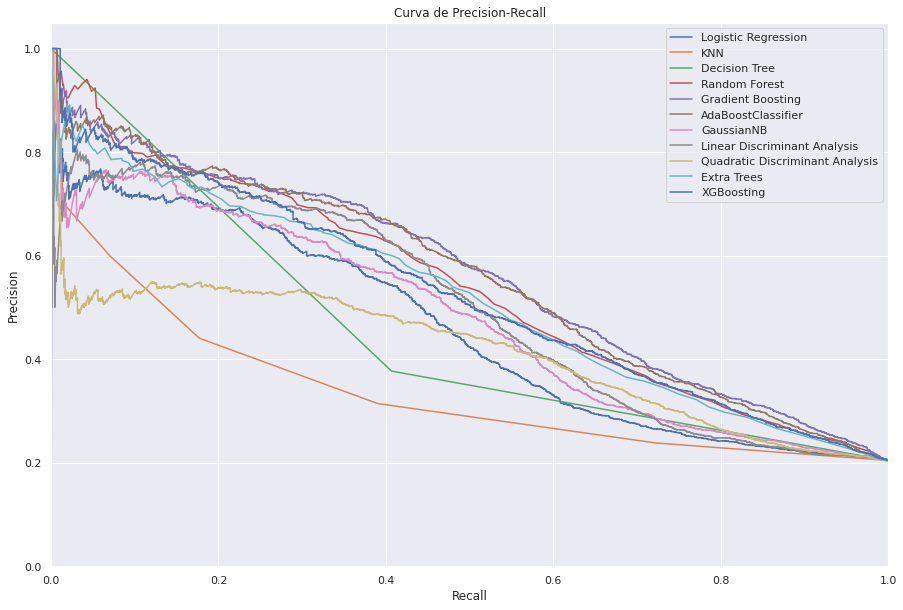

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve



results = []

# Plot das curvas de Precision-Recall
for model_name, model in models.items():
    m = model.fit(X,y)
    y_pred = m.predict_proba(df_OOT.drop(['ID','SAFRA','default'],axis=1))[:,1]
    precision, recall, threshold = precision_recall_curve(df_OOT['default'], y_pred)
    plt.plot(recall, precision, label=model_name)
    auprc = average_precision_score(df_OOT['default'], y_pred)
    results.append({'Model': model_name , 'AUPRC': auprc})

df_aurpc= pd.DataFrame(results)

# Configurações do plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall')
plt.legend(loc='best')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [92]:
df_aurpc.sort_values(by = 'AUPRC', ascending=False)

,Model,AUPRC
4,Gradient Boosting,0.560373
5,AdaBoostClassifier,0.554898
3,Random Forest,0.534567
10,XGBoosting,0.523694
9,Extra Trees,0.509964
7,Linear Discriminant Analysis,0.496647
6,GaussianNB,0.476671
0,Logistic Regression,0.456331
8,Quadratic Discriminant Analysis,0.413819
1,KNN,0.293621


## 7.2 Machine Learning Modeling - Balanced With SMOTE

In [93]:
#Com balanceamento
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score , cross_validate
from sklearn.metrics import average_precision_score

num_folds = 10
seed = 7

kfold = KFold(num_folds, shuffle=True , random_state=seed)

model_tree = DecisionTreeClassifier()
result_tree=cross_val_score(model_tree,X_smo,y_smo,cv=kfold,scoring='accuracy')
print("Accuracy Value: {:.4f}" .format(result_tree.mean()))

Accuracy Value: 0.7640


In [96]:
model_tester(X_smo,y_smo,models)

,Model,AUPRC
0,Logistic Regression,0.722458
1,KNN,0.642745
2,Decision Tree,0.700202
3,Random Forest,0.930283
4,Gradient Boosting,0.882501
5,AdaBoostClassifier,0.852801
6,GaussianNB,0.712226
7,Linear Discriminant Analysis,0.747792
8,Quadratic Discriminant Analysis,0.936847
9,Extra Trees,0.935081


In [ ]:
plot_aurpc(x_smo,y_smo,models)

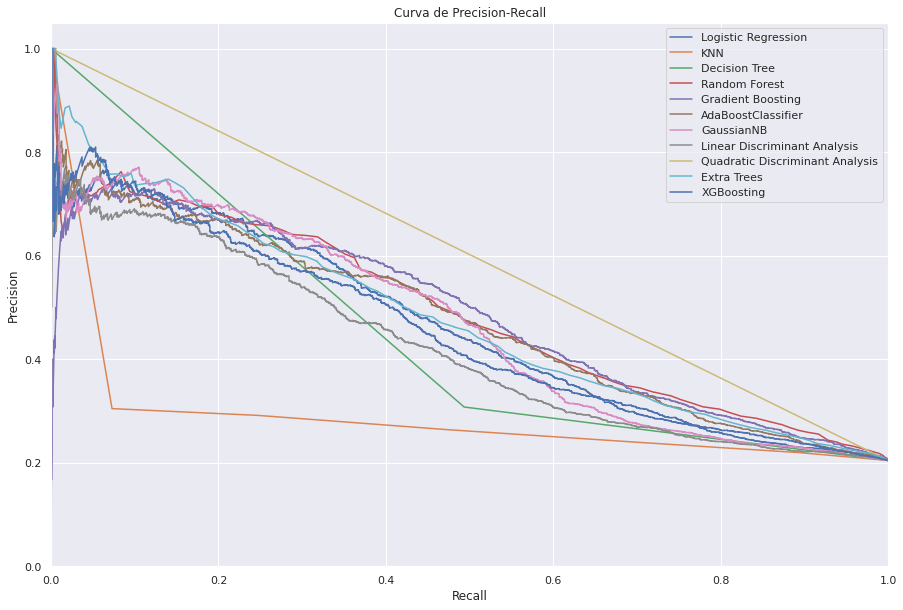

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


results = []

# Plot das curvas de Precision-Recall
for model_name, model in models.items():
    m = model.fit(X_smo,y_smo)
    y_pred = m.predict_proba(df_OOT.drop(['ID','SAFRA','default'],axis=1))[:,1]
    precision, recall, threshold = precision_recall_curve(df_OOT['default'], y_pred)
    plt.plot(recall, precision, label=model_name)
    auprc = average_precision_score(df_OOT['default'], y_pred)
    results.append({'Model': model_name , 'AUPRC': auprc})

df_aurpc= pd.DataFrame(results)

# Configurações do plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall')
plt.legend(loc='best')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

## 7.3 Machine Learning Modelling - Balanced DataSet with ADASYN

In [98]:
#Com balanceamento
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import KFold, cross_val_score , cross_validate
from sklearn.metrics import average_precision_score

num_folds = 10
seed = 7

kfold = KFold(num_folds, shuffle=True , random_state=seed)

model_tree = DecisionTreeClassifier()
result_tree=cross_val_score(model_tree,X_ada,y_ada,cv=kfold,scoring='accuracy')
print("Accuracy Value: {:.4f}" .format(result_tree.mean()))

Accuracy Value: 0.7623


In [99]:
model_tester(X_ada,y_ada,models)

,Model,AUPRC
0,Logistic Regression,0.706261
1,KNN,0.635143
2,Decision Tree,0.695027
3,Random Forest,0.926171
4,Gradient Boosting,0.876864
5,AdaBoostClassifier,0.843974
6,GaussianNB,0.694862
7,Linear Discriminant Analysis,0.732929
8,Quadratic Discriminant Analysis,0.937126
9,Extra Trees,0.930983


In [ ]:
plot_aurpc(X_ada,y_ada,models)

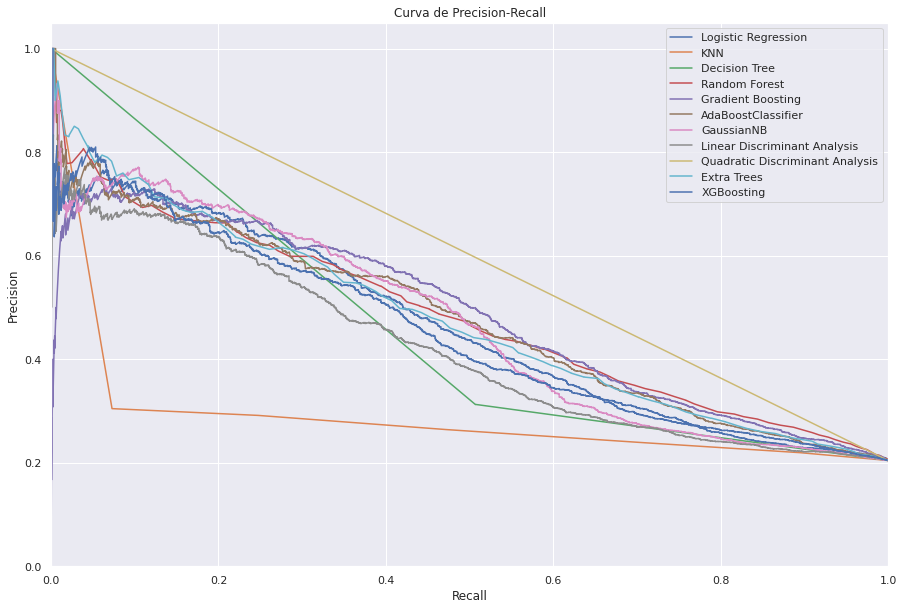

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


results = []

# Plot das curvas de Precision-Recall
for model_name, model in models.items():
    m = model.fit(X_smo,y_smo)
    y_pred = m.predict_proba(df_OOT.drop(['ID','SAFRA','default'],axis=1))[:,1]
    precision, recall, threshold = precision_recall_curve(df_OOT['default'], y_pred)
    plt.plot(recall, precision, label=model_name)
    auprc = average_precision_score(df_OOT['default'], y_pred)
    results.append({'Model': model_name , 'AUPRC': auprc})

df_aurpc= pd.DataFrame(results)

# Configurações do plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall')
plt.legend(loc='best')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# PASSO 8 - Hyperparameter Fine Tuning

In [95]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# Define the hyperparameter search space
param_space = {
    "learning_rate": Real(0.01, 1.0, prior="log-uniform"),
    "max_depth": Integer(1, 10),
    "n_estimators": Integer(50, 500),
    "min_child_weight": Integer(1, 10),
    "subsample": Real(0.5, 1.0, prior="uniform"),
    "colsample_bytree": Real(0.5, 1.0, prior="uniform"),
    "gamma": Real(1e-6, 1.0, prior="log-uniform"),
    "reg_alpha": Real(1e-9, 1.0, prior="log-uniform"),
    "reg_lambda": Real(1e-9, 1.0, prior="log-uniform"),
    "scale_pos_weight": Real(1e-6, 500, prior="log-uniform"),
    "objective": Categorical(["binary:logistic"]),
}

# Define the XGBoost classifier
clf = XGBClassifier(
    random_state=42,
    n_jobs=-1,
)

# Define the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=clf,
    search_spaces=param_space,
    scoring="average_precision",
    cv=5,
    n_jobs=-1,
    n_iter=20,
    verbose=0,
    random_state=42,
)

# Fit the BayesSearchCV object to the data
bayes_cv.fit(X_train, y_train)

# Print the best hyperparameters and best average precision score
print("Best hyperparameters: ", bayes_cv.best_params_)
print("Best AUPRC: {:.4f}".format(bayes_cv.best_score_))

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

# PASSO 9 -  Utilizando DataSet de Teste para Calibrar PD e Calcular PD, LGD e EAD. 

# PASSO 10 - Tradução e Interpretação do Erro

# PASSO 11 - Deploy Model To Production

## 10.1 Credit Class

In [105]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class CreditCard( object ):
    
    def __init__(self):
        self.home_path = 
        self.gender_scaler = 
        self.cols_scaler = 
        
    def data_cleaning(self,df1):
        
        
        return df1
    
    def feature_engineering(self,df2):
        
        return df2
    
    def data_preparation(self, df5):
        
        return df5[cols_select]
    
    def get_prediction(self, model, original_data, test_data):
        
        return original_data.to_json()

SyntaxError: invalid syntax (4000454909.py, line 11)

## 10.2 API Handler

## 10.3 API Tester

In [ ]:
data = {"model": model_tree }
with open('saved_steps2.pkl' , 'wb') as file:
    pickle.dump(data,file)

In [ ]:
with open('saved_steps2.pkl' , 'rb') as file:
    data =  pickle.load(file)

In [ ]:
classificator = data['model']

In [ ]:
classificator.predict(X)[0]

In [ ]:
cols_selected